In [1]:
import os
os.chdir("../..")

In [134]:
import rasterio as rio, rasterio.io, rasterio.windows
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import torch, torch.nn

import detectron2, detectron2.config, detectron2.checkpoint, detectron2.engine, detectron2.utils.visualizer

In [141]:
df = pd.read_pickle("./data/szprotawa/szprotawa_patches_256/annotation.pkl").set_geometry('bbox')
df = df[(df.bbox.area > 200) & (df.bbox.area < 500)]
df.iloc[0]

patch_number                                                          2751
global_geo_shape         POLYGON ((265634.0305229931 416461.5553409614,...
global_pixel_shape       POLYGON ((2441 12005, 2446 12047, 2466 12047, ...
local_pixel_shape        POLYGON ((137 -27, 142 15, 162 15, 162 -22, 13...
cut_local_pixel_shape    POLYGON ((140.2142857142857 0, 142 15, 162 15,...
bbox                     POLYGON ((140.2142857142857 0, 162 0, 162 15, ...
Name: 29, dtype: object

In [142]:
df.head()

,patch_number,global_geo_shape,global_pixel_shape,local_pixel_shape,cut_local_pixel_shape,bbox
29,2751,"POLYGON ((265634.0305229931 416461.5553409614,...","POLYGON ((2441 12005, 2446 12047, 2466 12047, ...","POLYGON ((137 -27, 142 15, 162 15, 162 -22, 13...","POLYGON ((140.2142857142857 0, 142 15, 162 15,...","POLYGON ((140.214 0.000, 162.000 0.000, 162.00..."
37,2881,"POLYGON ((269241.0603792864 416437.2240104362,...","POLYGON ((2554 28782, 2546 28816, 2575 28815, ...","POLYGON ((250 110, 242 144, 271 143, 277 109, ...","POLYGON ((250 110, 242 144, 256 143.5172413793...","POLYGON ((242.000 109.778, 256.000 109.778, 25..."
38,2882,"POLYGON ((269241.0603792864 416437.2240104362,...","POLYGON ((2554 28782, 2546 28816, 2575 28815, ...","POLYGON ((250 -18, 242 16, 271 15, 277 -19, 25...","POLYGON ((245.7647058823529 0, 242 16, 256 15....","POLYGON ((242.000 0.000, 256.000 0.000, 256.00..."
51,3028,"POLYGON ((265634.0305229931 416461.5553409614,...","POLYGON ((2441 12005, 2446 12047, 2466 12047, ...","POLYGON ((9 -27, 14 15, 34 15, 34 -22, 9 -27))","POLYGON ((12.21428571428571 0, 14 15, 34 15, 3...","POLYGON ((12.214 0.000, 34.000 0.000, 34.000 1..."
58,3151,"POLYGON ((269077.173486323 416415.9690550347, ...","POLYGON ((2653 28020, 2641 28091, 2665 28104, ...","POLYGON ((221 244, 209 315, 233 328, 247 244, ...","POLYGON ((221 244, 218.9718309859155 256, 245 ...","POLYGON ((218.972 244.000, 247.000 244.000, 24..."


In [188]:
df.iloc[1]['global_pixel_shape'].area, df.iloc[1]['bbox'].area

(945.0, 479.1111111111112)

In [189]:
df.iloc[1]['global_pixel_shape'].area, df.iloc[1]['bbox'].area

(945.0, 479.1111111111112)

In [190]:
df.iloc[1]['global_pixel_shape'].exterior.xy

(array('d', [2554.0, 2546.0, 2575.0, 2581.0, 2554.0]),
 array('d', [28782.0, 28816.0, 28815.0, 28781.0, 28782.0]))

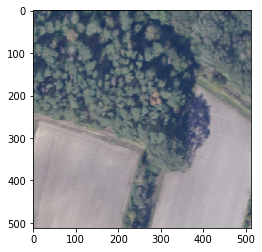

In [222]:
with rio.open("./data/szprotawa/RGB_szprotawa_transparent_mosaic_group1.tif") as f:
    im = f.read(window = rio.windows.Window(28600, 2400, 512, 512)).transpose(1,2,0)[:,:,:-1]
plt.imshow(im)

In [223]:
cfg = detectron2.config.get_cfg()
cfg.merge_from_file("./tboard_logs/retinanet_test_2020-01-21T23:40/config.yml")

In [165]:
cfg.TEST

CfgNode({'EXPECTED_RESULTS': [], 'EVAL_PERIOD': 50, 'KEYPOINT_OKS_SIGMAS': [], 'DETECTIONS_PER_IMAGE': 10, 'AUG': CfgNode({'ENABLED': False, 'MIN_SIZES': (400, 500, 600, 700, 800, 900, 1000, 1100, 1200), 'MAX_SIZE': 4000, 'FLIP': True}), 'PRECISE_BN': CfgNode({'ENABLED': False, 'NUM_ITER': 200})})

In [183]:
predictor = detectron2.engine.DefaultPredictor(cfg)

In [219]:
im2 = cv2.imread("./data/szprotawa/szprotawa_patches_256/patch_2881.png")[:,:,::-1]

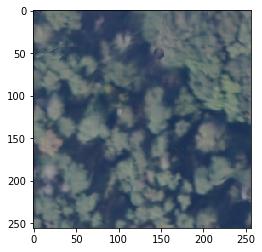

In [226]:
plt.imshow(im2)

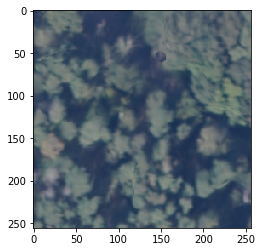

In [244]:
with rio.open("./data/szprotawa/RGB_szprotawa_transparent_mosaic_group1.tif") as f:
    im = f.read(window = rio.windows.Window(28670, 2300, 512, 512)).transpose(1,2,0)[:,:,:-1]
plt.imshow(im[:256,:256])

In [254]:
res = []
for i in range(20):
    for j in range(20):
        r=i
        c=j
        out = (im[r:r+256,c:c+256] == im2)
        res.append({"r": i, "c": j, "perc": out.mean()})
res = pd.DataFrame(res)
res[res['perc'] == res["perc"].max()]

,r,c,perc
82,4,2,1.0


In [265]:
from ipywidgets import IntSlider, interactive, VBox



In [303]:
from matplotlib.colors import NoNorm
def compare(r,c):
    g = im[r:r+256,c:c+256] == im2
    plt.figure(2)
    plt.imshow(g.mean(2)*255, cmap='gray', norm=NoNorm())

    
rslide = IntSlider(min=0, max=20)
cslide = IntSlider(min=0, max=20)
interactive_plot = interactive(compare, r=rslide, c=cslide)
# interactive_plot = interactive(compare, r=(0,20), c=(0,20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot
#VBox([rslide, cslide,interactive_plot])

interactive(children=(IntSlider(value=0, description='r', max=20), IntSlider(value=0, description='c', max=20)…

In [296]:
(im[4:4+256,2:2+256, ::] == im2).mean(2)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [275]:
VIntSlider()

IntSlider(value=0)

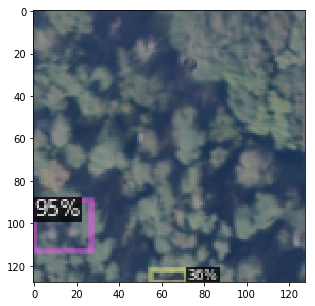

In [255]:
g = im[4:4+256,2:2+256, ::-1].copy()
pred = predictor(g)


vis = detectron2.utils.visualizer.Visualizer(g[:,:,::-1].copy(), {"thing_classes": ["SickTrees"]},
                                               scale=0.5)
vis = vis.draw_instance_predictions(pred["instances"].to("cpu"))
plt.figure(figsize=(5,5))
plt.imshow(vis.get_image())

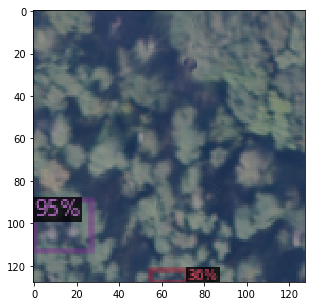

In [258]:
g = im2[:256,:256, ::-1].copy()
pred = predictor(g)


vis = detectron2.utils.visualizer.Visualizer(g[:,:,::-1].copy(), {"thing_classes": ["SickTrees"]},
                                               scale=0.5)
vis = vis.draw_instance_predictions(pred["instances"].to("cpu"))
plt.figure(figsize=(5,5))
plt.imshow(vis.get_image())

In [178]:
pred

{'instances': Instances(num_instances=1, image_height=1024, image_width=1024, fields=[pred_boxes = Boxes(tensor([[ 985.2849,  530.6889, 1023.6799,  615.8637]], device='cuda:0')), scores = tensor([0.1693], device='cuda:0'), pred_classes = tensor([0], device='cuda:0'), ])}

In [53]:
model = model_dict['model']

In [63]:
# [type(x) for x in model.values()]

In [305]:
import numpy as np

with rio.open("./data/szprotawa/RGB_szprotawa_transparent_mosaic_group1.tif") as f:
#     im = f.read(window = rio.windows.Window(28600, 2400, 512, 512)).transpose(1,2,0)[:,:,:-1]
    im = np.stack([f.read(i + 1, 
                          window=rio.windows.Window(28600, 2400, 512, 512)) for i in range(3)])

In [311]:
np.stack([np.zeros((12,12)), np.zeros((12,12))]).shape

(2, 12, 12)

In [ ]:
1

In [321]:
with rio.open("./data/szprotawa/RGB_szprotawa_transparent_mosaic_group1.tif") as f:
    a = f.read(1, window=rio.windows.Window(28600, 2400, 512, 512))
    b = np.stack([a])
    red_channel_img = np.moveaxis(b, 0, -1)

#         normalized_red_channel_img = red_channel_img / np.max(red_channel_img)
#         nir_img = np.moveaxis(np.stack([self.nir_tif_handler.read(1, 
#                                                                   window=rio.windows.Window(28600, 2400, 512, 512))
#                                                                   out_shape=(1,
#                                                                              int(normalized_red_channel_img.shape[0]),
#                                                                              int(normalized_red_channel_img.shape[1]))
        

#     ndvi = (nir_img - normalized_red_channel_img) / (normalized_red_channel_img + nir_img)
#     ndvi = (ndvi + 1)/2
#     ndvi = np.float32(ndvi)


In [322]:
red_channel_img.shape

(512, 512, 1)

In [323]:
red_channel_img.transpose(2, 0,1)

array([[[101,  99,  98, ...,  88,  88,  85],
        [102,  98,  95, ...,  89,  88,  86],
        [102,  95,  90, ...,  90,  89,  87],
        ...,
        [164, 165, 166, ..., 170, 180, 184],
        [166, 169, 170, ..., 164, 175, 182],
        [166, 170, 172, ..., 163, 173, 179]]], dtype=uint8)

In [324]:
a.shape

(512, 512)

In [325]:
b.shape

(1, 512, 512)

In [329]:
(a[..., np.newaxis] == red_channel_img).all()

True

In [330]:
import fiona

In [332]:
!ls data/szprotawa/


 RGB_szprotawa_transparent_mosaic_group1.tif   szprotawa_splits.pkl
 szprotawa_patches_256			       Szprotawa_translated_EVI.tif
'szprotawa shp'


In [350]:
a = fiona.open("./data/szprotawa/szprotawa shp/drzewa_szprotawa.shp")

In [337]:
a.close()

In [338]:
import rasterio as rio

In [347]:
with fiona.open("./data/szprotawa/szprotawa shp/drzewa_szprotawa.shp") as fopen, \
rio.open("./data/szprotawa/RGB_szprotawa_transparent_mosaic_group1.tif") as ropen:
    print(len(fopen))

1307


In [356]:
for i in range(len(a)):
    if a[i]['geometry']['type'] != 'Polygon':
        print(i)
        break